In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.ion()

from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris

from poliastro.twobody.propagation import propagate, cowell
from poliastro.ephem import build_ephem_interpolant
from poliastro.core.elements import rv2coe

from poliastro.core.util import norm
from poliastro.core.perturbations import atmospheric_drag, third_body, J2_perturbation
from poliastro.bodies import Earth, Moon
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D

# Atmospheric drag

The poliastro package now has several commonly used natural perturbations. One of them is atmospheric drag! See how one can monitor decay of the near-Earth orbit over time using our new module poliastro.twobody.perturbations!

In [2]:
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km ** 3 / u.s ** 2).value

orbit = Orbit.circular(Earth, 250 * u.km, epoch=Time(0.0, format="jd", scale="tdb"))

# parameters of a body
C_D = 2.2  # dimentionless (any value would do)
A = ((np.pi / 4.0) * (u.m ** 2)).to(u.km ** 2).value  # km^2
m = 100  # kg
B = C_D * A / m

# parameters of the atmosphere
rho0 = Earth.rho0.to(u.kg / u.km ** 3).value  # kg/km^3
H0 = Earth.H0.to(u.km).value

tofs = TimeDelta(np.linspace(0 * u.h, 100000 * u.s, num=2000))

rr = propagate(
    orbit,
    tofs,
    method=cowell,
    ad=atmospheric_drag,
    R=R,
    C_D=C_D,
    A=A,
    m=m,
    H0=H0,
    rho0=rho0,
)

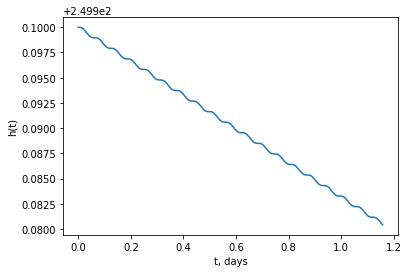

In [3]:
plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, rr.data.norm() - Earth.R);

# Evolution of RAAN due to the J2 perturbation

We can also see how the J2 perturbation changes RAAN over time!

In [4]:
r0 = np.array([-2384.46, 5729.01, 3050.46]) * u.km
v0 = np.array([-7.36138, -2.98997, 1.64354]) * u.km / u.s

orbit = Orbit.from_vectors(Earth, r0, v0)

tofs = TimeDelta(np.linspace(0, 48.0 * u.h, num=2000))

coords = propagate(
    orbit, tofs, method=cowell,
    ad=J2_perturbation, J2=Earth.J2.value, R=Earth.R.to(u.km).value
)

rr = coords.data.xyz.T.to(u.km).value
vv = coords.data.differentials["s"].d_xyz.T.to(u.km / u.s).value

# This will be easier to compute when this is solved:
# https://github.com/poliastro/poliastro/issues/257
raans = [rv2coe(k, r, v)[3] for r, v in zip(rr, vv)]

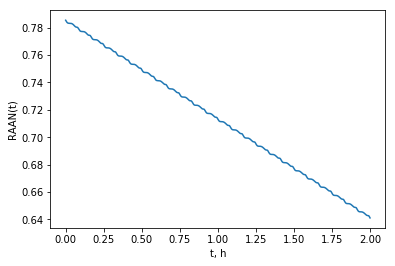

In [5]:
plt.ylabel("RAAN(t)")
plt.xlabel("t, h")
plt.plot(tofs.value, raans);

# 3rd body

Apart from time-independent perturbations such as atmospheric drag, J2/J3, we have time-dependend perturbations. Lets’s see how Moon changes the orbit of GEO satellite over time!

In [6]:
# database keeping positions of bodies in Solar system over time
solar_system_ephemeris.set("de432s")

epoch = Time(2454283.0, format="jd", scale="tdb")  # setting the exact event date is important

# create interpolant of 3rd body coordinates (calling in on every iteration will be just too slow)
body_r = build_ephem_interpolant(
    Moon, 28 * u.day, (epoch.value * u.day, epoch.value * u.day + 60 * u.day), rtol=1e-2
)

initial = Orbit.from_classical(
    Earth,
    42164.0 * u.km,
    0.0001 * u.one,
    1 * u.deg,
    0.0 * u.deg,
    0.0 * u.deg,
    0.0 * u.rad,
    epoch=epoch,
)

tofs = TimeDelta(np.linspace(0, 60 * u.day, num=1000))

# multiply Moon gravity by 400 so that effect is visible :)
rr = propagate(
    initial,
    tofs,
    method=cowell,
    rtol=1e-6,
    ad=third_body,
    k_third=400 * Moon.k.to(u.km ** 3 / u.s ** 2).value,
    third_body=body_r,
)

In [7]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr, label="orbit influenced by Moon")

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'solid', 'width': 5},
            …

# Thrusts

Apart from natural perturbations, there are artificial thrusts aimed at intentional change of orbit parameters. One of such changes is simultaineous change of eccenricy and inclination.

In [8]:
from poliastro.twobody.thrust import change_inc_ecc

ecc_0, ecc_f = 0.4, 0.0
a = 42164  # km
inc_0 = 0.0  # rad, baseline
inc_f = (20.0 * u.deg).to(u.rad).value  # rad
argp = 0.0  # rad, the method is efficient for 0 and 180
f = 2.4e-6  # km / s2

k = Earth.k.to(u.km ** 3 / u.s ** 2).value
s0 = Orbit.from_classical(
    Earth,
    a * u.km,
    ecc_0 * u.one,
    inc_0 * u.deg,
    0 * u.deg,
    argp * u.deg,
    0 * u.deg,
    epoch=Time(0, format="jd", scale="tdb"),
)

a_d, _, _, t_f = change_inc_ecc(s0, ecc_f, inc_f, f)

tofs = TimeDelta(np.linspace(0, t_f * u.s, num=1000))

rr2 = propagate(s0, tofs, method=cowell, rtol=1e-6, ad=a_d)

In [9]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr2, label='orbit with artificial thrust')

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'solid', 'width': 5},
            …